# Denoising using Deep Image Prior

## Introduction

This notebook is a playground replication of [Deep Image Prior](http://openaccess.thecvf.com/content_cvpr_2018/papers/Ulyanov_Deep_Image_Prior_CVPR_2018_paper.pdf) by Ulyanov et al. According to the paper, DNNs have an inductive bias toward _natural images_: that is, a DNN tends to produce naturally looking images rather than noisy or blurry ones. In this notebook we will try to perform _denoising_ of an image.

We will create a net that **takes random noise** and **generates the noisy image** from it (we assume we do not have the clean image, we will use it only for measuring performance). Because of the inductive bias of deep nets toward natural images we expect a clean version of the image to emerge earlier in the process before the net overfits and produces the noise as well.

We will try three different architectures:

* 1D-Generator (generating from 1D noise)
* 2D-Generator (generating from 2D noise)
* 2D-Generator with skip-connections

## Credits

Contributors: Shmuel Londner (now TAU) and Matan Schlanger as part of requirements to the course "Introduction to Computer Vision" at Weizman Institute. The helper functions were provided by the course's staff.

##Imports

In [ ]:
# %tensorflow_version 2.x
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

import torch
import torch.nn as nn
import torch.nn.functional as F
# import os
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import tempfile
import PIL
import IPython.display

# Install pillow=5.4.1
!pip install -U -q "pillow~=5.4.1"

# Install livelossplot
!pip install -U -q "livelossplot~=0.3.0"

##Download dataset

In [ ]:

# download images
# !wget -q https://wis-intro-vision-2019.wikidot.com/local--files/assignments/ex5-data.tar.gz
!tar -zxf data.tar.gz && rm -f data.tar.gz
# # download images

# !wget -q https://wis-intro-vision-2019.wikidot.com/local--files/assignments/ex5-data-v2.tar.gz

# !tar -zxf ex5-data-v2.tar.gz && rm -f ex5-data-v2.tar.gz



tar (child): ex5-data.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


## Utility Methods

You may want to use the provided utility functions, instead of implementing them yourselves.

### I/O

In [ ]:
# def gdrive_mount():
#   if os.path.isdir('/gdrive'):
#     return True

#   import google.colab
#   google.colab.drive.mount('/gdrive')  


# def gdrive_path(path):
#   return os.path.join('/gdrive/My Drive', path)

In [ ]:


# Low-Level Utility Methods

def _img_to_float32(image, bounds=(0, 1)):
  """Receives an `image` and range `bounds`, 
     normalizes it and converts it to `float32`. 

  Arguments:
    image (np.ndarray): the image
    bounds (Tuple[float, float], optional): expected minimum and maximum values 
                                            of image pixels

  Returns:
    np.ndarray: the converted image, with `dtype=np.float32`.

  """
  minval, maxval = bounds
  image = np.asarray(image, dtype=np.float32) / 255.0
  image = np.clip((maxval - minval) * image + minval, minval, maxval)
  return image


def _img_to_uint8(image, bounds=(0, 1)):
  """Receives an `image` and range `bounds`, 
     noramlizes it and converts it to `uint8`.

  Arguments:
    image (np.ndarray): the image
    bounds (Tuple[float, float], optional): expected minimum and maximum values 
                                            of image pixels

  Returns:
    np.ndarray: the converted image, with `dtype=np.uint8`.
    
  """
  if image.dtype != np.uint8:
    minval, maxval = bounds
    image = (image.astype(np.float32) - minval) / (maxval - minval)
    image = (image * 255.0).round().clip(0, 255).astype(np.uint8)
  return image


def _check_path(path):
  """Checks whether a path exists. 
  If not, the required missing directories are created"""
  path = os.path.abspath(path)
  if not os.path.exists(os.path.dirname(path)):
    os.makedirs(os.path.dirname(path))
  return path


# High-Level Utility Methods

def imread(path, size=(256, 256), bounds=(0, 1)):
  """Reads an image, changes its size to match `size` (may crop and lose data),
     and converts it to float.
  
  Arguments:
    path (str): path to image
    size (Tuple[int, int], optional): desired image size
    bounds (Tuple[float, float], optional): expected minimum and maximum values 
                                            of image pixels
  
  Returns:
    image (np.ndarray): the image, where it values are in the given `bounds`.
  
  """
  image = PIL.Image.open(path).convert(mode='RGB')
  if size is not None:
    scale_factor = max([float(size[dim]) / float(image.size[dim]) for dim in range(2)])
    new_size = [int(scale_factor * sz) for sz in image.size]
    image = image.resize(new_size, PIL.Image.LANCZOS)
    left, top = [(image.size[dim] - size[dim]) // 2 for dim in range(2)] 
    image = image.crop((left, top, left + size[0], top + size[1]))
  image = _img_to_float32(image, bounds)
  return image


def imwrite(path, image, bounds=(0, 1), **kwargs):  
  """Normalize `image` and save it to `path`.

  Arguments:
    path (str): saving location
    image (np.ndarray): the image
    bounds (Tuple[float, float], optional): expected minimum and maximum values 
                                            of image pixels
  """  
  image = _img_to_uint8(image, bounds)
  path = _check_path(path)
  image = PIL.Image.fromarray(image)
  image.save(path, **kwargs)


def imshow(image, path=None, **kwargs):
  """Normalize `image`, save it, and show it.

  Arguments:
    path (str): saving location (if None, image is save to temporary location)
    image (np.ndarray): the image
  
  """
  fd = None
  if path is None:
    fd, path = tempfile.mkstemp(suffix='.png')
  
  imwrite(path, image, **kwargs)  
  output = IPython.display.Image(path)
  
  if fd is not None:
    os.close(fd)
  
  display(output)


# colab version
try:
  import google.colab.widgets
  
  def imshow_tabs(noisy, result, clean=None, paths=None, **kwargs):
    """Normalizes input images (`noisy`, `result`, and possible `clean`)
    and shows them in tabs.

    Arguments:
      noisy (np.ndarray): noisy image to show.
      result (np.ndarray): cleaned image to show.
      clean (np.ndarray, optional): ground truth clean image to show.
      paths (List[str]], optional): list of locations to save the images to.
    
    """
    images = [noisy, result]
    titles = ['noisy', 'result']
    if clean is not None:
      images.append(clean)
      titles.append('clean')
    if paths is None:
      paths = [None] * len(titles)
    assert len(paths) == len(titles)
    
    tab = google.colab.widgets.TabBar(titles)
    
    for title, path, image in zip(titles, paths, images):
      with tab.output_to(title):
        imshow(image, path=path, **kwargs)


# jupyter version
except ImportError:
  import ipywidgets
  
  def imshow_tabs(noisy, result, clean=None, paths=None, **kwargs):
    """Normalizes input images (`noisy`, `result`, and possible `clean`)
    and shows them in tabs.

    Arguments:
      noisy (np.ndarray): noisy image to show.
      result (np.ndarray): cleaned image to show.
      clean (np.ndarray, optional): ground truth clean image to show.
      paths (List[str]], optional): list of locations to save the images to.
    
    """
    images = [noisy, result]
    titles = ['noisy', 'result']
    if clean is not None:
      images.append(clean)
      titles.append('clean')
    if paths is None:
      paths = [None] * len(titles)
    assert len(paths) == len(titles)

    tab = ipywidgets.Tab([ipywidgets.Output() for _ in titles])
    
    for i, (title, path, image) in enumerate(zip(titles, paths, images)):
      tab.set_title(i, title)
      with tab.children[i]:
        imshow(image, path=path, **kwargs)
    
    display(tab)

### Evaluation

In [ ]:
def root_mean_square_error(a, b):
  """Computes the RMSE between two images, or between two batches of images.
  
  Arguments:
    a (np.ndarray): the first image (or batch of images, stacked along axis 0)
    b (np.ndarray): the second image (or batch of images, stacked along axis 0)
  
  Returns:
    rmse (float / np.ndarray): if `a` has 2 or 3 dimensions, returns the
                               RMSE between `a` and `b`.
                               if `a` has 4 dimensions, returns a list of
                               RMSE between corresponding images in `a`
                               and `b`. 
  """
  assert a.ndim in {2, 3, 4}, '`a` should have 2/3/4 dimensions'
  assert a.shape == b.shape, '`a` and `b` should have the same shape'
  
  # batch of images
  if a.ndim == 4:  
    mse = np.mean((a - b)**2, axis=(1, 2, 3))
  
  # single image
  else:            
    mse = np.mean((a - b)**2)
  
  return np.sqrt(mse)
    

def peak_signal_noise_ratio(a, b, bounds=(0, 1)):
  """Computes the PSNR between two images, or between two batches of images.
  
  Arguments:
    a (np.ndarray): the first image (or batch of images, stacked along axis 0)
    b (np.ndarray): the second image (or batch of images, stacked along axis 0)
    bounds (Tuple[float, float]): the valid bounds of `a` and `b`.
 
  Returns:
    psnr (float / np.ndarray): if `a` has 2 or 3 dimensions, returns the
                               PSNR between `a` and `b`.
                               if `a` has 4 dimensions, returns list of
                               PSNR between corresponding images in `a`
                               and `b`.
  """
  assert a.ndim in {2, 3, 4}, '`a` should have 2/3/4 dimensions'
  assert a.shape == b.shape, '`a` and `b` should have the same shape'
  
  minval, maxval = bounds
  rmse = root_mean_square_error(a, b)
  return 20 * np.log10(maxval - minval) - 20 * np.log10(rmse)

### Datasets

In [ ]:
def list_dataset(dataset_dir='dataset'):
  """Lists the images in a given dataset.
  
  Arguments:
    dataset_dir (str): where the dataset is.
  
  Returns:
    dataset (List[str]): list of paths to images in the dataset.
  """
  return sorted([os.path.join(dataset_dir, fname) for fname in os.listdir(dataset_dir)])

### Training

In [ ]:
def add_noise(images, scale=0.1, bounds=(0, 1)):

  minval, maxval = bounds

  noise = np.random.uniform(-scale, scale, size=images.shape)

  return np.clip(images + noise, minval, maxval)



In [ ]:
import livelossplot
import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid', 'seaborn-notebook'])

class Tracker(object):
  def __init__(self, fig_path=None):
    """Creates a tracker, that keeps track of training.
    
    You should probably create a tracker when creating the network, because they
    are usually coupled.

    Arguments:
      fig_path (str, optional): where to save an image of the tracker's plots.

    """
    self._plot = livelossplot.PlotLosses(
      plot_extrema=False,
      fig_path=fig_path,
      metric2title={'loss': 'Loss', 'rmse': 'RMSE', 'psnr': 'PSNR'}
    )
  
  def update(self, logs):
    """Update the tracker's data.
    
    Arguments:
      logs (dict): a dictionary with data for the tracker. Valid keys are
                   'loss', 'rmse', 'pnsr' and 'val_*' (for the mentioned keys).
                   'val_*' key means value on validation data.
                   the value corresponding to the key should be a single value,
                   not an array.
    
    """
    self._plot.update(logs)
  
  def draw(self):
    """Refresh the tracker's plot."""
    self._plot.draw()

In [ ]:
class DeepImagePriorTrainer(object):
  def __init__(self, noise_input, noisy_image, clean_image=None, device=None):
    """Trainer for Deep Image Prior, on a given pre-set example.
    
    Arguments:
      noise_input (np.ndarray): vector of the noise to use as the network's input.
      noisy_image (np.ndarray): the noisy image the network tries to learn.
      clean_image (np.ndarray, optional): the clean image (ground truth).
                                          SHOULD BE USED FOR VALIDATION ONLY!!!
      device (str, optional): where to run. If None, chooses device automatically.
                              Usually better to keep this unchanged.
    
    """
    if device is None:
      device = "cuda:0" if torch.cuda.is_available() else "cpu"
    self.device = device
    
    if noise_input.ndim == 3:
      noise_input = np.transpose(noise_input, (2, 0, 1))
    self.noise = noise_input[None, ...]
    self.noise_t = torch.as_tensor(self.noise, dtype=torch.float32, device=self.device)

    self.noisy = np.transpose(noisy_image, (2, 0, 1))[None, ...]
    self.noisy_t = torch.as_tensor(self.noisy, dtype=torch.float32, device=self.device)
    
    if clean_image is not None:
      self.clean = np.transpose(clean_image, (2, 0, 1))[None, ...]
      self.clean_t = torch.as_tensor(self.clean, dtype=torch.float32, device=self.device)
    else:
      self.clean = None
      self.clean_t = None

  def train(self, net, optimizer, criterion, epochs, output_rate=50, tracker=None):
    """Trains a Deep Image Prior network on the pre-set example (input noise and noisy image).
    
    Arguments:
      net (torch.nn.Module): your network. receives the noise, and should return the image.
      optimizer (torch.optim.Optimizer): optimizer (make sure it's optimizing net's parameters).
      criterion: loss function.
      epochs (int): number of training iterations.
      output_rate (int): how frequently (number of epochs) should the tracker's plot be refreshed.
      tracker (Tracker, optional): tracker of the training.
      
    """
    net = net.to(self.device)
    net.train()
    
    for step in range(epochs):
      optimizer.zero_grad()
      cleaned_t = net(self.noise_t)
      loss_t = criterion(cleaned_t, self.noisy_t)
      loss_t.backward()
      optimizer.step()
      
      logs = {}
      cleaned = cleaned_t.cpu().detach().numpy()

      # report learning on provided (noisy) image
      loss = loss_t.item()
      logs['rmse'] = root_mean_square_error(cleaned, self.noisy)[0]
      logs['psnr'] = peak_signal_noise_ratio(cleaned, self.noisy)[0]
      logs['loss'] = loss

      # report learning on ground-truth (clean) image
      if self.clean is not None:
        with torch.no_grad():
          val_loss_t = criterion(cleaned_t, self.clean_t)
        val_loss = val_loss_t.item()
        logs['val_rmse'] = root_mean_square_error(cleaned, self.clean)[0]
        logs['val_psnr'] = peak_signal_noise_ratio(cleaned, self.clean)[0]
        logs['val_loss'] = val_loss
      
      if tracker is not None:
        tracker.update(logs)
      
      if step % output_rate == 0:
        if tracker is not None:
          tracker.draw()
        else:
          print(logs)  # print logs
        
    if tracker is not None:
      tracker.draw()
  
  def eval(self, net):
    """Predicts the image by feeding `net` with the pre-set noise.
    
    Arguments:
      net (torch.nn.Module): network to feed with input noise, and take its prediction as image.
      
    Returns:
      image (np.ndarray): the predicted imaged.
    """
    net = net.to(self.device)
    net.eval()
    
    cleaned_t = net(self.noise_t)
    cleaned = cleaned_t.cpu().detach().numpy()
    return np.transpose(cleaned[0, ...], (1, 2, 0))

In [ ]:
def example_main_loop(net, opt_class, opt_kwargs, criterion, noise_size, image_path, sigma, epochs, tracker=None):
  optimizer = opt_class(net.parameters(), **opt_kwargs)
  noise_input = np.random.normal(size=noise_size).astype(np.float32)
  clean_image = imread(image_path, size=(256, 256))
  noisy_image = add_noise(clean_image, sigma)
  dip = DeepImagePriorTrainer(noise_input, noisy_image, clean_image)
  dip.train(net, optimizer, criterion, epochs=epochs, tracker=tracker)
  result_image = dip.eval(net)
  imshow_tabs(noisy_image, result_image, clean_image)
  resultsDict={}
  resultsDict['result_image']=result_image
  resultsDict['PSNR_out']=peak_signal_noise_ratio(result_image,clean_image)
  resultsDict['PSNR_in']=peak_signal_noise_ratio(noisy_image,clean_image)
  return resultsDict

### 1. 1D-Generator

Construct a "generating" net that expects as input a 1D random noise vector, passes it through a fully connected layer to arranges it in a 2D feature space. Add "upsampling" convolutional layers to produce the target image.

#### Design Choices
1. "width" of the different layers (number of filters)
2. Number of different layers: how many "upsamples", by what scale factor each time
3. "Upsample" method: transposed convolution vs. interp + conv (see [here](https://distill.pub/2016/deconv-checkerboard/))
4. How to init weights: uniform/random/zero?
5. What loss to use? L1/L2/CE?
6. Regularization?
7. Solver: SGD (with and without momentum) / ADAM
8. Learning rates: try different values `1e-5`, `1e-3`, `1e-1`, `1e1`. \\
See effect of learning rate on optimization progress: slow progress vs divergence.

In [ ]:

class Generator1D(nn.Module):
  basic2DSize=8
  finalSize=256
  def init_weights(self,m):
    if type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d :
      torch.nn.init.xavier_uniform_(m.weight)
  def __init__(self):
    super(Generator1D, self).__init__()
    self.lin1=nn.Linear(64,self.basic2DSize**2,bias=True)
    self.expander=nn.Conv2d(in_channels=1,out_channels=3,kernel_size=1,padding=0)
    self.modList=nn.ModuleList()
    channelsWidth=[3,16,64,64,16,3]
    for i in range(5):
      upSampleLayer=nn.Upsample(scale_factor=2,mode='bilinear')
      convLayer=nn.Conv2d(in_channels=channelsWidth[i],out_channels=channelsWidth[i+1],kernel_size=5,padding=2)
      self.modList.append(upSampleLayer)
      self.modList.append(convLayer)
    self.apply(self.init_weights)
  def forward(self, x):
    nonLin=nn.Tanh()
    x1=nn.functional.relu(self.lin1(x))
    x2d=x1.reshape(-1,1,self.basic2DSize,self.basic2DSize)
    x2dEx=(self.expander(x2d))
    y=x2dEx
    for i,m in enumerate(self.modList):
      y=nonLin(m(y))
    return y

### 2. 2D-Generator

Construct a "U-net": start with 2D noise the same size as the input image (but maybe more/less channels). Add some conv + stride/pooling layers to reduce spatial dimensions and creating an "information bottleneck", then use "upsampling" blocks to recover the original spatial resolution.

#### Design Choices
1. "width" of the different layers
2. Number of different layers: how many "upsamples", by what scale factor each time
3. "Upsample" method: transposed convolution vs. interp + conv (see [here](https://distill.pub/2016/deconv-checkerboard/))
4. How to init weights: uniform/random/zero?
5.Use the loss function that worked best for you in the previous part
6. Regularization?


In [ ]:
class Generator2D(nn.Module):
  def init_weights_uniform(self,m):
    if type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d :
      torch.nn.init.uniform_(m.weight)
  def init_weights_zero(self,m):
    if type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d :
      torch.nn.init.constant_(m.weight, 0)
  def init_weights_normal(self,m):
    if type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d :
      torch.nn.init.normal_(m.weight)
  
  def init_weights_xavier_uniform(self,m):
    if type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d :
      torch.nn.init.xavier_uniform_(m.weight)
  def init_weights_xavier_normal(self,m):
    if type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d :
      torch.nn.init.xavier_normal_(m.weight)
      
  def init_weights_he_uniform(self,m):
    if type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d :
      torch.nn.init.kaiming_normal_(m.weight)
  def init_weights_he_normal(self,m):
    if type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d :
      torch.nn.init.kaiming_normal_(m.weight) 
      
      
  def __init__(self, channels = [3, 10, 50, 60, 100] , 
               upsample_mode = 'deconv', 
               scale_factor = 2, 
               weight_initialization = 'uniform'):
    
    super(Generator2D, self).__init__()
    layers = []
    depth = len(channels)-1
    for i in range(depth) :
      layers.append( nn.Conv2d(in_channels=channels[i],
                               out_channels=channels[i+1], 
                               kernel_size=3, padding=1) )
      layers.append( nn.ReLU() )
      layers.append( nn.MaxPool2d(scale_factor, scale_factor) )
                   
    
    for i in reversed(range(depth)):
      if upsample_mode == 'deconv':
        layers.append( nn.ConvTranspose2d(in_channels=channels[i+1],
                                          out_channels=channels[i], 
                                          kernel_size = scale_factor + 2, stride=scale_factor, padding=1) )
        layers.append( nn.ReLU() )

      elif upsample_mode=='bilinear' or upsample_mode=='nearest':
        layers.append( nn.Upsample(scale_factor=scale_factor, 
                                   mode=upsample_mode) )
        layers.append( nn.Conv2d(in_channels=channels[i+1],
                                 out_channels=channels[i], 
                                 kernel_size=3, padding=1) )
        layers.append( nn.ReLU() )
      
    self.model = nn.Sequential(*layers)
    
    #weight initialization
    if weight_initialization == 'uniform':
      self.model.apply(self.init_weights_uniform)
    elif weight_initialization == 'random':
      self.model.apply(self.init_weights_normal)
    elif weight_initialization == 'zero':
      self.model.apply(self.init_weights_zero) 
    elif weight_initialization == 'xavier_uniform':
      self.model.apply(self.init_weights_xavier_uniform) 
    elif weight_initialization == 'xavier_normal':
      self.model.apply(self.init_weights_xavier_normal)
    elif weight_initialization == 'he_uniform':
      self.model.apply(self.init_weights_he_uniform) 
    elif weight_initialization == 'he_normal':
      self.model.apply(self.init_weights_he_normal)  
    
    #print(self.model)

  def forward(self, x):
    return self.model(x)

### 3. 2D-Generator with skip-connections

Use the same "U-net" architecture from previous part, but now add "skip connections" connecting feature maps of same spatial resolution from the "downscale" part to the "upscale" part.

#### Design Choices
1. "width" of the different layers, and specifically, the "width" of the skip connections.
2. How to propagate the information passed through "skip connections": do we add it (like residual links), or concat it (like "densenet")?

In [ ]:
class Generator2DS(nn.Module):
  def init_weights_xavier_normal(self,m):
    if type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d :
      torch.nn.init.xavier_normal_(m.weight)    
  
  def __init__(self, channels = [3, 10, 50, 60, 100],
               skip_channels =       [0,  3,  50,  60],
               propagation = 'concat'): #if propagation == 'add' then skip_channels are ignored and channels is used
    
    super(Generator2DS, self).__init__()
    scale_factor = 2
    self.skip_channels = skip_channels
    self.propagation = propagation
    
    self.down_layers = nn.ModuleList()
    self.up_layers = nn.ModuleList()
    self.skip_layers = nn.ModuleList()
    
    if self.propagation == 'add':
      self.skip_channels = [0] * len(channels)
    
    assert len(channels) == (len(skip_channels)+1)
    depth = len(channels)-1
    #downsample layers
    for i in range(depth) :
      self.down_layers.append(nn.Sequential( 
            nn.Conv2d(in_channels=channels[i], out_channels=channels[i+1], kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(scale_factor, scale_factor)
                        ))
      if self.propagation == 'concat':
        if self.skip_channels[i] > 0:
          self.skip_layers.append(nn.Sequential( 
                nn.Conv2d(in_channels=channels[i+1], out_channels=self.skip_channels[i], kernel_size=3, padding=1), 
                nn.ReLU()
                            ))
        else:
            self.skip_layers.append(None)
            

    #print(depth) #DEBUG
    for i in reversed(range(depth)):
        if self.propagation == 'concat':
          self.up_layers.append(nn.Sequential(
                  nn.ConvTranspose2d(in_channels=channels[i+1] + self.skip_channels[i], out_channels=channels[i], 
                                 kernel_size = scale_factor + 2, stride=scale_factor, padding=1),
                  nn.ReLU() 
                          ))
        elif self.propagation == 'add':
          self.up_layers.append(nn.Sequential(
                  nn.ConvTranspose2d(in_channels=channels[i+1], out_channels=channels[i], 
                                 kernel_size = scale_factor + 2, stride=scale_factor, padding=1),
                  nn.ReLU() 
                          ))

    #print(self.down_layers) #DEBUG
    #print(self.skip_layers) #DEBUG
    #print(self.up_layers) #DEBUG
    
    #weight initialization
    self.apply(self.init_weights_xavier_normal)

  def forward(self, x):
    deep_outputs = []
    skip_outputs = []
    input1 = x
    depth = len(self.down_layers)
    
    
    for i in range(depth) :
      deep_outputs.append( self.down_layers[i](input1) )
      if self.propagation == 'concat' and self.skip_layers[i]:
        skip_outputs.append( self.skip_layers[i](deep_outputs[i]) )
      else:
        skip_outputs.append(None)
      input1 = deep_outputs[i]
    
    
    input2 = deep_outputs[-1]
    for i in range(depth) :
      input2_with_skip = input2
      if self.propagation == 'concat' and self.skip_layers[depth-i-1]:
        input2_with_skip = torch.cat((input2, skip_outputs[depth-i-1]),1)
      elif self.propagation == 'add':
        input2_with_skip = torch.add(input2, deep_outputs[depth-i-1])
      #print(i) #DEBUG
      #print(skip_outputs[depth-i-1].shape) #DEBUG
      #print(self.skip_layers[depth-i-1]) #DEBUG
      input2 = self.up_layers[i](input2_with_skip)

    return input2


## Experiments for 1D Generator

Please run your experiments below this point.

A method to compute average PSNR over all images of dataset:

In [ ]:
def runOverDataset(currNet,epochs,lr, noise_size):
  import os
  psnrsList=[]
  cleanImagesList = []
  datasetName='dataset-v2/'
  for f in os.listdir(datasetName):
    t=Tracker()
    resDict=example_main_loop(currNet,opt_class=torch.optim.Adam,criterion=nn.functional.mse_loss,noise_size=noise_size,image_path=datasetName+f,sigma=0.1,epochs=epochs,tracker=t,opt_kwargs={'lr':lr})
    psnrsList.append(resDict['PSNR_out'])
    cleanImagesList.append(resDict['result_image'])
  psnrsArr=np.array(psnrsList)
  psnrsLin=10**(0.05*psnrsArr)
  meanPsnrsLin=np.mean(psnrsLin)
  meanPsnrs=20*np.log10(meanPsnrsLin)
  print('Mean PSNR: ',meanPsnrs)
  results={}
  results['psnrsList'] = psnrsList
  results['cleanImagesList'] = cleanImagesList
  return results

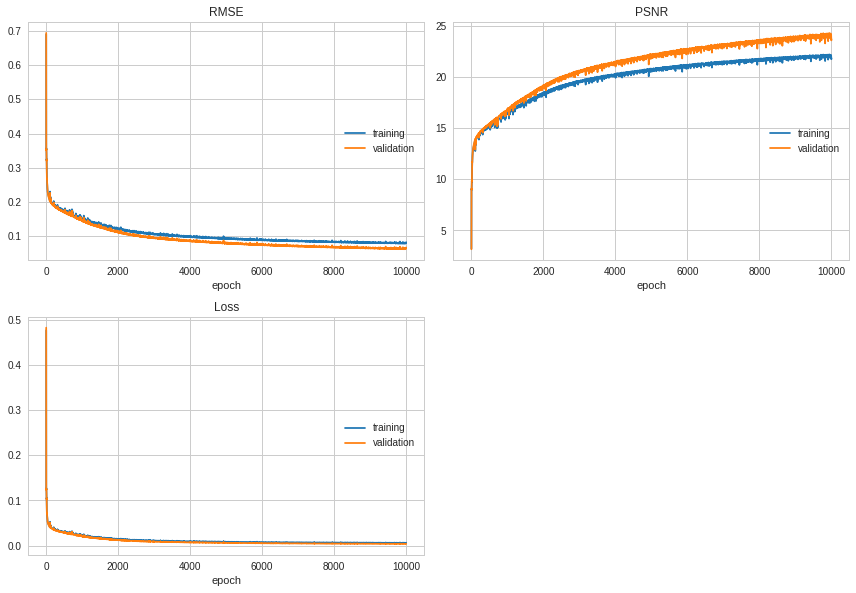

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

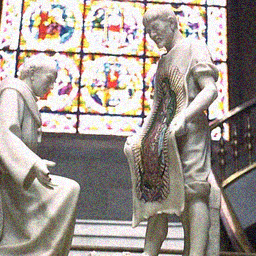

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

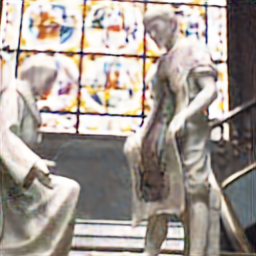

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

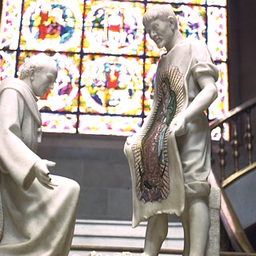

<IPython.core.display.Javascript object>

{'result_image': array([[[ 0.26720527,  0.2543664 ,  0.23282029],
        [ 0.19529031,  0.11950636,  0.11351906],
        [ 0.4636061 ,  0.16860403,  0.1597667 ],
        ...,
        [ 0.06271949,  0.16248642,  0.12641776],
        [ 0.11516968,  0.1811037 ,  0.08326323],
        [ 0.15100423,  0.1525443 ,  0.18538426]],

       [[ 0.3127914 ,  0.12904459,  0.02312297],
        [ 0.23591413,  0.15039416, -0.08600836],
        [ 0.623489  ,  0.45480397,  0.21691342],
        ...,
        [ 0.16105802,  0.07998686,  0.09728783],
        [ 0.20587873,  0.26342002,  0.13786349],
        [ 0.22969434,  0.19577333,  0.20516051]],

       [[ 0.15991479,  0.16669883,  0.17170772],
        [ 0.13263749,  0.1610699 ,  0.10460713],
        [ 0.63015926,  0.4042243 ,  0.3009929 ],
        ...,
        [ 0.26499248,  0.19964463,  0.23357695],
        [ 0.09144495,  0.12743491,  0.22069594],
        [ 0.08253889,  0.0722283 ,  0.14718898]],

       ...,

       [[ 0.58674324,  0.6313921 ,  0.57920

In [ ]:
import os
t=Tracker()
currNet=Generator1D()
dataSet=list_dataset('dataset-v2')
resDict=example_main_loop(currNet,opt_class=torch.optim.Adam,criterion=nn.functional.mse_loss,noise_size=64,image_path='dataset-v2/05.png',sigma=0.1,epochs=10000,tracker=t,opt_kwargs={'lr':1e-3})
print(resDict)

In [ ]:
epochs=5000
lr=1e-3
noise_size=64
currNet=Generator1D()
resDict=runOverDataset(currNet,epochs,lr,noise_size)
cleanedImgs=resDict['cleanImagesList']
psnrsList=resDict['psnrsList']
for i in range(len(psnrsList)):
  print('Image PSNR: ',psnrsList[i])
  imshow(cleanedImgs[i])

IsADirectoryError: ignored

Compute number of parameters:

In [ ]:
pytorch_total_params = sum(p.numel() for p in currNet.parameters())
print(pytorch_total_params)

## Experiments for 2D Generator

Initial guess:

In [ ]:
t2d=Tracker()
currNet2d=Generator2D(upsample_mode = 'deconv', 
                      channels = [3, 16, 32, 64, 128, 256, 512],
                      scale_factor = 2,
                      weight_initialization = 'xavier_uniform'
                     )
dataSet=list_dataset('dataset-v2')
example_main_loop(currNet2d,opt_class=torch.optim.Adam,
                  criterion=nn.functional.mse_loss,noise_size=(256,256,3),
                  image_path='dataset-v2/05.png',
                  sigma=0.1,epochs=2000,tracker=t2d,opt_kwargs={'lr':1e-3})

Now let us check with a higher scale factor (and less layers to fit the initial image size)

In [ ]:
t2d=Tracker()
currNet2d=Generator2D(upsample_mode = 'deconv', 
                      channels = [3, 16, 32, 64, 128],
                      scale_factor = 4,
                      weight_initialization = 'xavier_uniform'
                     )
dataSet=list_dataset('dataset-v2')
example_main_loop(currNet2d,opt_class=torch.optim.Adam,
                  criterion=nn.functional.mse_loss,noise_size=(256,256,3),
                  image_path='dataset-v2/05.png',
                  sigma=0.1,epochs=2000,tracker=t2d,opt_kwargs={'lr':1e-3})


Not so good. Let us go back to scale factor 2 and add layers

In [ ]:
t2d=Tracker()
currNet2d=Generator2D(upsample_mode = 'deconv', 
                      channels = [3, 16, 32, 64, 128, 256, 512, 1024, 2048],
                      scale_factor = 2,
                      weight_initialization = 'xavier_uniform'
                     )
dataSet=list_dataset('dataset-v2')
example_main_loop(currNet2d,opt_class=torch.optim.Adam,
                  criterion=nn.functional.mse_loss,noise_size=(256,256,3),
                  image_path='dataset-v2/05.png',
                  sigma=0.1,epochs=2000,tracker=t2d,opt_kwargs={'lr':1e-3})

Not incredibly better and much slower. Let us try with less layers but more channels.

In [ ]:
t2d=Tracker()
currNet2d=Generator2D(upsample_mode = 'deconv', 
                      channels = [3, 16, 64, 256, 1024, 4096],
                      scale_factor = 2,
                      weight_initialization = 'xavier_uniform'
                     )
dataSet=list_dataset('dataset-v2')
_ = example_main_loop(currNet2d,opt_class=torch.optim.Adam,
                  criterion=nn.functional.mse_loss,noise_size=(256,256,3),
                  image_path='dataset-v2/05.png',
                  sigma=0.1,epochs=2000,tracker=t2d,opt_kwargs={'lr':1e-3})

A bit worse and much slower. Let us decrease the channels number and change the upsampling method to bilinear interpolation.

In [ ]:
t2d=Tracker()
currNet2d=Generator2D(upsample_mode = 'bilinear', 
                      channels = [3, 10, 10, 50, 60],
                      scale_factor = 2,
                      weight_initialization = 'xavier_uniform'
                     )
dataSet=list_dataset('dataset-v2')
_ = example_main_loop(currNet2d,opt_class=torch.optim.Adam,
                  criterion=nn.functional.mse_loss,noise_size=(256,256,3),
                  image_path='dataset-v2/05.png',
                  sigma=0.1,epochs=2000,tracker=t2d,opt_kwargs={'lr':1e-3})

Not bad. Let us compare to nearest neighbor upsampling method and slighty increase the number of channels.

In [ ]:
t2d=Tracker()
currNet2d=Generator2D(upsample_mode = 'nearest', 
                      channels = [3, 10, 50, 60, 100],
                      scale_factor = 2,
                      weight_initialization = 'xavier_uniform'
                     )
dataSet=list_dataset('dataset-v2')
_ = example_main_loop(currNet2d,opt_class=torch.optim.Adam,
                  criterion=nn.functional.mse_loss,noise_size=(256,256,3),
                  image_path='dataset-v2/05.png',
                  sigma=0.1,epochs=2000,tracker=t2d,opt_kwargs={'lr':1e-3})

Not very good. Let us go back to deconvolution and change the initialization method to He normal.

In [ ]:
t2d=Tracker()
currNet2d=Generator2D(upsample_mode = 'deconv', 
                      channels = [3, 10, 50, 60, 100],
                      scale_factor = 2,
                      weight_initialization = 'he_normal'
                     )
dataSet=list_dataset('dataset-v2')
_ = example_main_loop(currNet2d,opt_class=torch.optim.Adam,
                  criterion=nn.functional.mse_loss,noise_size=(256,256,3),
                  image_path='dataset-v2/05.png',
                  sigma=0.1,epochs=2000,tracker=t2d,opt_kwargs={'lr':1e-3})

For reference let us compare with Gorlot normal

In [ ]:
t2d=Tracker()
currNet2d=Generator2D(upsample_mode = 'deconv', 
                      channels = [3, 10, 50, 60, 100],
                      scale_factor = 2,
                      weight_initialization = 'xavier_normal'
                     )
dataSet=list_dataset('dataset-v2')
_ = example_main_loop(currNet2d,opt_class=torch.optim.Adam,
                  criterion=nn.functional.mse_loss,noise_size=(256,256,3),
                  image_path='dataset-v2/05.png',
                  sigma=0.1,epochs=2000,tracker=t2d,opt_kwargs={'lr':1e-3})

Very good, we will remember that for our best guess. For now let's see if bilinear is better with a zeroed weight initialization.

In [ ]:
t2d=Tracker()
currNet2d=Generator2D(upsample_mode = 'bilinear', 
                      channels = [3, 10, 50, 60, 100],
                      scale_factor = 2,
                      weight_initialization = 'zero'
                     )
dataSet=list_dataset('dataset-v2')
_ = example_main_loop(currNet2d,opt_class=torch.optim.Adam,
                  criterion=nn.functional.mse_loss,noise_size=(256,256,3),
                  image_path='dataset-v2/05.png',
                  sigma=0.1,epochs=2000,tracker=t2d,opt_kwargs={'lr':1e-3})

Quite bad, as expected. We'll go back to our best guess and let it run a lot of epochs, with both deconvolution and bilinear upsampling methods.

First deconvolution:

In [ ]:
t2d=Tracker()
currNet2d=Generator2D(upsample_mode = 'deconv', 
                      channels = [3, 10, 50, 60, 100],
                      scale_factor = 2,
                      weight_initialization = 'xavier_normal'
                     )
dataSet=list_dataset('dataset-v2')
_ = example_main_loop(currNet2d,opt_class=torch.optim.Adam,
                  criterion=nn.functional.mse_loss,noise_size=(256,256,3),
                  image_path='dataset-v2/05.png',
                  sigma=0.1,epochs=20000,tracker=t2d,opt_kwargs={'lr':1e-3})

And bilinear

In [ ]:
t2d=Tracker()
currNet2d=Generator2D(upsample_mode = 'bilinear', 
                      channels = [3, 10, 50, 60, 100],
                      scale_factor = 2,
                      weight_initialization = 'xavier_normal'
                     )
dataSet=list_dataset('dataset-v2')
_ = example_main_loop(currNet2d,opt_class=torch.optim.Adam,
                  criterion=nn.functional.mse_loss,noise_size=(256,256,3),
                  image_path='dataset-v2/05.png',
                  sigma=0.1,epochs=20000,tracker=t2d,opt_kwargs={'lr':1e-3})

And nearest-neighbor:

In [ ]:
t2d=Tracker()
currNet2d=Generator2D(upsample_mode = 'nearest', 
                      channels = [3, 10, 50, 60, 100],
                      scale_factor = 2,
                      weight_initialization = 'xavier_normal'
                     )
dataSet=list_dataset('dataset-v2')
_ = example_main_loop(currNet2d,opt_class=torch.optim.Adam,
                  criterion=nn.functional.mse_loss,noise_size=(256,256,3),
                  image_path='dataset-v2/05.png',
                  sigma=0.1,epochs=20000,tracker=t2d,opt_kwargs={'lr':1e-3})

Let us display the result for nearest-neighbor before overfitting begins (Around 3000 epochs):

In [ ]:
t2d=Tracker()
currNet2d=Generator2D(upsample_mode = 'nearest', 
                      channels = [3, 10, 50, 60, 100],
                      scale_factor = 2,
                      weight_initialization = 'xavier_normal'
                     )
dataSet=list_dataset('dataset-v2')
_ = example_main_loop(currNet2d,opt_class=torch.optim.Adam,
                  criterion=nn.functional.mse_loss,noise_size=(256,256,3),
                  image_path='dataset-v2/05.png',
                  sigma=0.1,epochs=3000,tracker=t2d,opt_kwargs={'lr':1e-3})

Let us compute the average PSNR over all the dataset for the deconvolution option, which converges faster

In [ ]:
currNet2d=Generator2D(upsample_mode = 'deconv', 
                      channels = [3, 10, 50, 60, 100],
                      scale_factor = 2,
                      weight_initialization = 'xavier_normal'
                     )

results=runOverDataset(currNet2d,epochs=2500,lr=1e-3, noise_size=(256,256,3))

In [ ]:
pytorch_total_params = sum(p.numel() for p in currNet2d.parameters())
print(pytorch_total_params)

## Experiments for 2D Generator with skip-connections

First guess based on our best guess in the previous section:

In [ ]:
t2ds=Tracker()
currNet2ds=Generator2DS(channels = [3, 10, 50, 60, 100],
               skip_channels =       [0,  0,  4,  4],
               propagation = 'concat'
                     )
dataSet=list_dataset('dataset-v2')
_ = example_main_loop(currNet2ds,opt_class=torch.optim.Adam,
                  criterion=nn.functional.mse_loss,noise_size=(256,256,3),
                  image_path='dataset-v2/05.png',
                  sigma=0.1,epochs=3000,tracker=t2ds,opt_kwargs={'lr':1e-3})

Comparison with propagation with addition:

In [ ]:
t2ds=Tracker()
currNet2ds=Generator2DS(channels = [3, 10, 50, 60, 100],
               skip_channels =       [0,  0,  4,  4],
               propagation = 'add'
                     )
dataSet=list_dataset('dataset-v2')
_ = example_main_loop(currNet2ds,opt_class=torch.optim.Adam,
                  criterion=nn.functional.mse_loss,noise_size=(256,256,3),
                  image_path='dataset-v2/05.png',
                  sigma=0.1,epochs=3000,tracker=t2ds,opt_kwargs={'lr':1e-3})

So concatenation is better - apparently because it is trainable and basically covers the addition capabiliy.
Let's check wider skip channels :

In [ ]:
t2ds=Tracker()
currNet2ds=Generator2DS(channels = [3, 10, 50, 60, 100],
               skip_channels =       [3,  10,  50,  60],
               propagation = 'concat'
                     )
dataSet=list_dataset('dataset-v2')
_ = example_main_loop(currNet2ds,opt_class=torch.optim.Adam,
                  criterion=nn.functional.mse_loss,noise_size=(256,256,3),
                  image_path='dataset-v2/05.png',
                  sigma=0.1,epochs=2000,tracker=t2ds,opt_kwargs={'lr':1e-3})

The lower layers are closer to the noise so let us reduce their influence on the expansion part:

In [ ]:
t2ds=Tracker()
currNet2ds=Generator2DS(channels = [3, 10, 50, 60, 100],
               skip_channels =       [0,  3,  50,  60],
               propagation = 'concat'
                     )
dataSet=list_dataset('dataset-v2')
_ = example_main_loop(currNet2ds,opt_class=torch.optim.Adam,
                  criterion=nn.functional.mse_loss,noise_size=(256,256,3),
                  image_path='dataset-v2/05.png',
                  sigma=0.1,epochs=2000,tracker=t2ds,opt_kwargs={'lr':1e-3})

What about increasing the weight of the deepest layers?

In [ ]:
t2ds=Tracker()
currNet2ds=Generator2DS(channels = [3, 10, 50, 60, 100],
               skip_channels =       [0,  3,  60,  100],
               propagation = 'concat'
                     )
dataSet=list_dataset('dataset-v2')
_ = example_main_loop(currNet2ds,opt_class=torch.optim.Adam,
                  criterion=nn.functional.mse_loss,noise_size=(256,256,3),
                  image_path='dataset-v2/05.png',
                  sigma=0.1,epochs=2000,tracker=t2ds,opt_kwargs={'lr':1e-3})

And increasing the width of the layers:

In [ ]:
t2ds=Tracker()
currNet2ds=Generator2DS(channels = [3, 10, 64, 100, 128],
               skip_channels =       [0,  3,  100,  100],
               propagation = 'concat'
                     )
dataSet=list_dataset('dataset-v2')
_ = example_main_loop(currNet2ds,opt_class=torch.optim.Adam,
                  criterion=nn.functional.mse_loss,noise_size=(256,256,3),
                  image_path='dataset-v2/05.png',
                  sigma=0.1,epochs=2000,tracker=t2ds,opt_kwargs={'lr':1e-3})

So we did not any revolutionary influence of the parameters.
We shall calculate PSNR with one of the nets which worked a bit better:

In [ ]:
t2ds=Tracker()
currNet2ds=Generator2DS(channels = [3, 10, 50, 60, 100],
               skip_channels =       [0,  3,  50,  60],
               propagation = 'concat'
                     )
dataSet=list_dataset('dataset-v2')


results=runOverDataset(currNet2ds,epochs=2000,lr=1e-3, noise_size=(256,256,3))

In [ ]:
cleanedImgs=results['cleanImagesList']
psnrsList=results['psnrsList']
for i in range(len(psnrsList)):
  print('Image PSNR: ',psnrsList[i])
  imshow(cleanedImgs[i])

And computing its number of parameters:

In [ ]:
pytorch_total_params = sum(p.numel() for p in currNet2ds.parameters())
print(pytorch_total_params)